<a href="https://colab.research.google.com/github/Arunim10/Hackfest/blob/main/Copy_of_water_management2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import code
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import soundfile as sf
!sudo apt-get install libportaudio2
!pip install sounddevice
import sounddevice as sd
import queue
import os

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
import pandas as pd
import numpy as np
import os
import sklearn

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import IPython.display as ipd
import librosa
import librosa.display

In [ ]:
!dir


drive  feat.npy  label.npy  sample_data  saved_models


In [ ]:
metadata=pd.read_csv('/content/drive/MyDrive/water_shufflefinal.csv')
metadata.head()

,audio,leakage
0,/content/drive/MyDrive/Water dataset/Non-Leak/...,0
1,/content/drive/MyDrive/Water dataset/Leak/1724...,1
2,/content/drive/MyDrive/Water dataset/Leak/3.1....,1
3,/content/drive/MyDrive/Water dataset/Leak/1.6....,1
4,/content/drive/MyDrive/Water dataset/Leak/003_...,1


In [ ]:
metadata.iloc[2][0]

'/content/drive/MyDrive/Water dataset/Leak/3.1.02.0345.wav'

In [ ]:
filename='/content/drive/MyDrive/Water dataset/Leak/3.1.02.0345.wav'
#/content/drive/MyDrive/Water dataset/leak/005_07573-20180826.wav

In [ ]:
audio_file_path='/content/drive/MyDrive/watermanage/Leak'


In [ ]:
wave_audio=metadata.iloc[2][0]

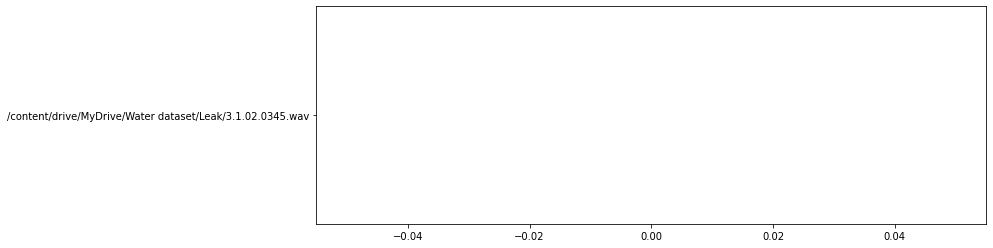

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

In [ ]:
wave_audio=metadata.iloc[2][0]

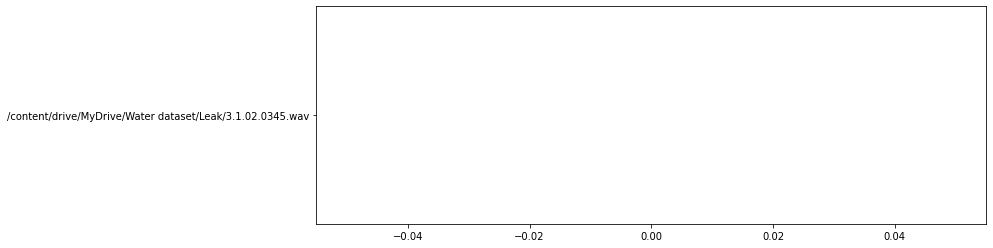

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

In [ ]:
def extract_feature(file_name=None):
    if file_name: 
        print('Extracting', file_name)
        X, sample_rate = sf.read(file_name, dtype='float32')
    else:  
        device_info = sd.query_devices(None, 'input')
        sample_rate = int(device_info['default_samplerate'])
        q = queue.Queue()
        def callback(i,f,t,s): q.put(i.copy())
        data = []
        with sd.InputStream(samplerate=sample_rate, callback=callback):
            while True: 
                if len(data) < 100000: data.extend(q.get())
                else: break
        X = np.array(data)

    if X.ndim > 1: X = X[:,0]
    X = X.T

    # short term fourier transform
    stft = np.abs(librosa.stft(X))

    # mfcc (mel-frequency cepstrum)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=8000, n_mfcc=40,fmin=30).T,axis=0)

    # chroma
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=8000).T,axis=0)

    # melspectrogram
    mel = np.mean(librosa.feature.melspectrogram(X, sr=8000,fmin=30).T,axis=0)

    # spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=8000,fmin=30).T,axis=0)

    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=8000,fmin=30).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz


In [ ]:
def parse_audio_files(parent_dir,file_ext='*.wav'):
    sub_dirs = os.listdir(parent_dir)
    sub_dirs.sort()
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        if os.path.isdir(os.path.join(parent_dir, sub_dir)):
            for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
                try: mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
                except Exception as e:
                    print("[Error] extract feature error in %s. %s" % (fn,e))
                    continue
                ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
                features = np.vstack([features,ext_features])
                # labels = np.append(labels, fn.split('/')[1])
                labels = np.append(labels, label)
            print("extract %s features done" % (sub_dir))
    return np.array(features), np.array(labels, dtype = np.int)

In [ ]:
def parse_predict_files(parent_dir,file_ext='*.wav'):
    features = np.empty((0,193))
    filenames = []
    for fn in glob.glob(os.path.join(parent_dir, file_ext)):
        mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
        ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
        features = np.vstack([features,ext_features])
        filenames.append(fn)
        print("extract %s features done" % fn)
    return np.array(features), np.array(filenames)


In [ ]:
# def features_extractor(file):
#     audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
#     mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
#     mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
#     return mfccs_scaled_features

In [ ]:
# import numpy as np
# from tqdm import tqdm
# ### Now we iterate through every audio file and extract features 
# ### using Mel-Frequency Cepstral Coefficients
# extracted_features=[]
# for index_num,row in tqdm(metadata.iterrows()):
#     file_name = os.path.join((row["audio"]))
#     final_class_labels=row["leakage"]
#     data=features_extractor(file_name)
#     extracted_features.append([data,final_class_labels])

In [ ]:
# extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
# extracted_features_df.head()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [ ]:
# X=np.array(extracted_features_df['feature'].tolist())
# y=np.array(extracted_features_df['class'].tolist())

In [ ]:
# X.shape

In [ ]:
# y

In [ ]:
features, labels = parse_audio_files('/content/drive/MyDrive/Water dataset')
np.save('feat.npy', features)
np.save('label.npy', labels)
import numpy as np
import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Load data from numpy file
X =  np.load('/content/feat.npy')
y =  np.load('/content/label.npy').ravel()

Extracting /content/drive/MyDrive/Water dataset/Leak/008_12854-20180811.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/004_07573-20180817.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/006_07573-20180831.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/007_07573-20180905.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/005_07573-20180826.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/009_05494-20180810.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/003_05593-20180927.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/012_16174-20171130.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/011_05576-20171123.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/015_05557-20190321.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/016_12835-20180523.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/018_05569-20181002.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/019_05500-20180809.wav
Extracting /

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Extracting /content/drive/MyDrive/Water dataset/Leak/1.2.04.0415.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.3.01.0330.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.3.03.0400.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.3.02.0345.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.3.04.0415.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.4.02.0345.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.4.01.0330.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.4.03.0400.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.4.04.0415.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.5.02.0345.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.5.03.0400.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.5.01.0330.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.5.04.0415.wav
Extracting /content/drive/MyDrive/Water dataset/Leak/1.6.01.0330.wav
Extracting /content/drive/MyDrive/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
X_train

array([[-1.63062637e+02, -1.37473612e+01, -1.90651588e+01, ...,
        -1.19653610e-01,  3.15114059e-02, -2.63409022e-02],
       [-1.75609146e+02,  7.99382019e+01, -9.05922413e+00, ...,
         9.42133173e-02, -2.33401880e-03,  6.51397316e-02],
       [-1.49077805e+02,  6.37061806e+01,  3.81316261e+01, ...,
         2.89341450e-02,  4.45508227e-02, -2.34060364e-02],
       ...,
       [-2.77681793e+02,  5.54526405e+01, -7.13506508e+00, ...,
         2.58367648e-02,  6.52647148e-02, -5.69300585e-02],
       [-2.48290573e+02,  7.09315643e+01,  2.06789150e+01, ...,
        -3.89011400e-02,  4.84887396e-02, -4.31139098e-02],
       [-5.21533813e+01, -4.68016129e+01, -3.76899261e+01, ...,
         2.43867885e-03,  5.24091058e-03,  1.17640815e-02]])

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
X_train.shape


(112, 193)

In [ ]:
X_test.shape

(28, 193)

In [ ]:
y_train.shape

(112,)

In [ ]:
y_test.shape

(28,)

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Input,Convolution1D,MaxPool1D,GlobalMaxPool1D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
input_length=193
from keras import models,optimizers,losses
import tensorflow as tf

In [ ]:
### No of classes
# num_labels=1

In [ ]:
from keras.backend import batch_normalization
nclass=1
inp = Input(shape=(input_length,1))
x = Convolution1D(16, 3, activation='relu', padding="valid")(inp)
x = Convolution1D(16, 3, activation='relu', padding="valid")(x)

    
x = Convolution1D(32, 3, activation='relu', padding="valid")(x)
x = Convolution1D(32, 3, activation='relu', padding="valid")(x)
x = BatchNormalization()(x)

    
x = Convolution1D(64, 3, activation='relu', padding="valid")(x)
x = Convolution1D(64, 3, activation='relu', padding="valid")(x)
x = BatchNormalization()(x)
    
x = Convolution1D(256, 3, activation='relu', padding="valid")(x)
x = GlobalMaxPool1D()(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(nclass, activation='sigmoid')(x)

model = models.Model(inputs=inp, outputs=out)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])

In [ ]:
# model.summary()

In [ ]:
model.fit(X_train,y_train,batch_size=15,epochs=15,validation_data=(X_test, y_test),verbose=1)

Epoch 1/15
8/8 [==============================] - 3s 98ms/step - loss: 0.9738 - acc: 0.5625 - val_loss: 0.6920 - val_acc: 0.4643
Epoch 2/15
8/8 [==============================] - 0s 49ms/step - loss: 0.7335 - acc: 0.6250 - val_loss: 0.6909 - val_acc: 0.5000
Epoch 3/15
8/8 [==============================] - 0s 54ms/step - loss: 0.6346 - acc: 0.7054 - val_loss: 0.6881 - val_acc: 0.5357
Epoch 4/15
8/8 [==============================] - 0s 51ms/step - loss: 0.5911 - acc: 0.6964 - val_loss: 0.6836 - val_acc: 0.7857
Epoch 5/15
8/8 [==============================] - 0s 55ms/step - loss: 0.5814 - acc: 0.6786 - val_loss: 0.6734 - val_acc: 0.7857
Epoch 6/15
8/8 [==============================] - 0s 50ms/step - loss: 0.4640 - acc: 0.7589 - val_loss: 0.6784 - val_acc: 0.6786
Epoch 7/15
8/8 [==============================] - 0s 45ms/step - loss: 0.3430 - acc: 0.8125 - val_loss: 0.6678 - val_acc: 0.6429
Epoch 8/15
8/8 [==============================] - 0s 49ms/step - loss: 0.3246 - acc: 0.7946 - val

In [ ]:
# ## Trianing my model
# from tensorflow.keras.callbacks import ModelCheckpoint
# from datetime import datetime 

# num_epochs = 10
# num_batch_size = 32

# checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
#                                verbose=1, save_best_only=True)
# start = datetime.now()

# model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


# duration = datetime.now() - start
# print("Training completed in time: ", duration)

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.6071428656578064


In [ ]:
X_test[1]

array([-2.79368164e+02,  5.46747932e+01, -7.37466764e+00,  9.77781963e+00,
        5.90038013e+00,  4.72458172e+00,  2.55581260e+00,  4.32015753e+00,
        5.56787491e+00,  5.17571211e+00,  3.77596569e+00,  3.35864067e+00,
        4.14305162e+00,  5.02392817e+00,  3.50711703e+00,  2.90899158e+00,
        3.59998012e+00,  4.33786678e+00,  3.72389650e+00,  2.78873920e+00,
        3.65858388e+00,  4.49031019e+00,  3.13023973e+00,  2.87242270e+00,
        3.35029578e+00,  3.65153909e+00,  3.39443374e+00,  2.80365324e+00,
        2.86737514e+00,  2.66457033e+00,  2.81586528e+00,  2.55213141e+00,
        2.53144002e+00,  2.65850830e+00,  3.51225090e+00,  2.63426971e+00,
        2.28445411e+00,  2.95313239e+00,  2.68133426e+00,  1.79020417e+00,
        8.48446250e-01,  8.95979583e-01,  9.08010900e-01,  8.77034962e-01,
        8.66414368e-01,  8.86376143e-01,  9.11453247e-01,  8.98144007e-01,
        9.00854707e-01,  9.13831413e-01,  9.34144199e-01,  8.99596393e-01,
        2.45813203e+00,  